In [1]:

import json
import joblib
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRanker
from itertools import accumulate
from event_vectorizer import EventVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt


In [2]:

#loading data
with open("interactions_ranked_soft_with_friends.json", "r") as f:
    data = json.load(f)

vectorizer = EventVectorizer()
vectorizer.fit(data)

X_raw, y_raw, groups = [], [], []
user_vecs = []

#vectorize users
for entry in data:
    profile = vectorizer.transform_user_profile(entry["user_profile"])
    history = vectorizer.transform_user_history(entry["user_history"])
    user_vecs.append(np.concatenate([profile, history]))

kmeans = KMeans(n_clusters=3, random_state=42).fit(user_vecs)
cluster_ids = kmeans.predict(user_vecs)


In [3]:

X_tmp, y_tmp = [], []
for i, entry in enumerate(data):
    profile = vectorizer.transform_user_profile(entry["user_profile"])
    history = vectorizer.transform_user_history(entry["user_history"])
    event = vectorizer.transform_event(entry["event"])

    friends = entry.get("friends_attended", [])
    friend_hist_vecs = [vectorizer.transform_event(f_event) for f_event in friends]
    if friend_hist_vecs:
        avg_friend_hist_vec = np.mean(friend_hist_vecs, axis=0).reshape(1, -1)
        event_vec_reshaped = event.reshape(1, -1)
        friend_hist_sim = cosine_similarity(avg_friend_hist_vec, event_vec_reshaped)[0][0]
    else:
        friend_hist_sim = 0.0

    cluster = [cluster_ids[i]]
    full_vec = np.concatenate([
        profile * 5,
        history * 4,
        event * 2,
        [friend_hist_sim * 2],
        cluster
    ])

    if -1 in full_vec:
        continue

    X_tmp.append(full_vec)
    y_tmp.append(entry["label"])

    is_last = i == len(data) - 1
    next_profile = data[i + 1]["user_profile"] if not is_last else None
    if is_last or entry["user_profile"] != next_profile:
        X_raw.extend(X_tmp)
        y_raw.extend(y_tmp)
        groups.append(len(X_tmp))
        X_tmp = []
        y_tmp = []


In [4]:

X = np.array(X_raw)
y = [int(round(label * 10)) for label in y_raw]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, y_train, train_groups = [], [], []
X_test, y_test, test_groups = [], [], []

starts = [0] + list(accumulate(groups))[:-1]
ends = list(accumulate(groups))

for i, (start, end) in enumerate(zip(starts, ends)):
    if i < int(len(groups) * 0.8):
        X_train.extend(X_scaled[start:end])
        y_train.extend(y[start:end])
        train_groups.append(end - start)
    else:
        X_test.extend(X_scaled[start:end])
        y_test.extend(y[start:end])
        test_groups.append(end - start)

model = LGBMRanker(
    n_estimators=100,
    learning_rate=0.05,
    objective="lambdarank",
    verbosity=-1,
    label_gain=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
)
model.fit(X_train, y_train, group=train_groups)


LGBMRanker(label_gain=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
           learning_rate=0.05, objective='lambdarank', verbosity=-1)

/Users/dmitrodubina/Downloads/diplo-sport/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


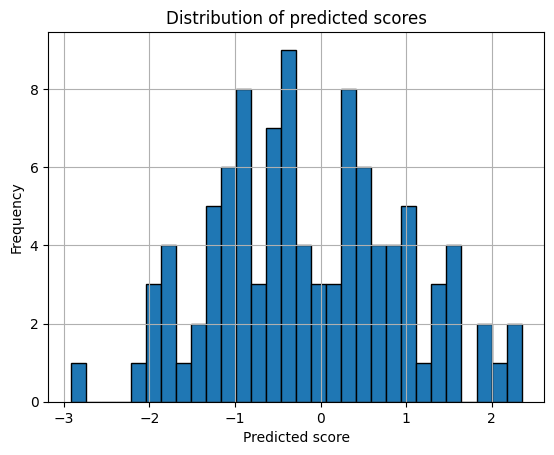

In [11]:

#predict and plots
y_pred_test = model.predict(X_test)
plt.hist(y_pred_test, bins=30, edgecolor='k')
plt.title("Distribution of predicted scores")
plt.xlabel("Predicted score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [6]:

def ndcg_at_5(y_true, y_pred, groups):
    score = 0
    idx = 0
    for g in groups:
        yt = y_true[idx:idx+g]
        yp = y_pred[idx:idx+g]
        idx += g
        if len(yt) < 5:
            continue
        score += ndcg_score([yt], [yp], k=5)
    return score / len(groups)


In [7]:

def precision_at_5(y_true, y_pred, groups):
    score = 0
    idx = 0
    for g in groups:
        yt = y_true[idx:idx+g]
        yp = y_pred[idx:idx+g]
        idx += g
        if len(yt) < 5:
            continue
        top_k = np.take(yt, np.argsort(yp)[::-1][:5])
        score += np.mean(top_k > 0)
    return score / len(groups)


In [8]:

def map_at_5(y_true, y_pred, groups):
    total_score = 0
    idx = 0
    for g in groups:
        yt = y_true[idx:idx+g]
        yp = y_pred[idx:idx+g]
        idx += g
        if len(yt) < 5:
            continue
        order = np.argsort(yp)[::-1][:5]
        top_k = np.take(yt, order)
        hits = 0
        score = 0
        for i, label in enumerate(top_k):
            if label > 0:
                hits += 1
                score += hits / (i + 1)
        total_score += score / min(hits, 5) if hits else 0
    return total_score / len(groups)


In [9]:
print("NDCG@5:", round(ndcg_at_5(y_test, y_pred_test, test_groups), 4))
print("Precision@5:", round(precision_at_5(y_test, y_pred_test, test_groups), 4))
print("MAP@5:", round(map_at_5(y_test, y_pred_test, test_groups), 4))


NDCG@5: 0.858
Precision@5: 0.68
MAP@5: 0.9005
